In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Mathursan Balathas\AppData\Local\Temp\ipykernel_15176\950759743.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [86]:
df=pd.read_csv('Dataset/gold_price_data.csv') #reading the data 
df.head()

,Date,Value
0,01/01/1970,35.2
1,01/04/1970,35.1
2,01/07/1970,35.4
3,01/10/1970,36.2
4,01/01/1971,37.4


In [87]:
df.columns

Index(['Date', 'Value'], dtype='object')

In [88]:
df['Date']=pd.to_datetime(df['Date'],infer_datetime_format=True,format='%d/%m/%Y') #change the date type to date format

In [89]:
df['Value'] = df['Value'] * 100

In [90]:
df.set_index('Date',inplace=True) #coverting Date cloum into index

In [91]:
df.head()

,Value
Date,
1970-01-01,3520.0
1970-04-01,3510.0
1970-07-01,3540.0
1970-10-01,3620.0
1971-01-01,3740.0


<AxesSubplot:xlabel='Date'>

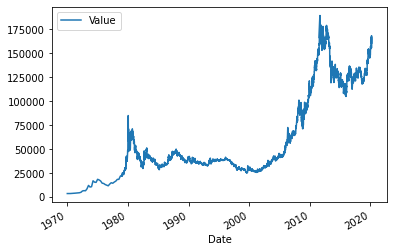

In [92]:
df.plot()

In [93]:
df.isna().sum()  #checking for null values

Value    0
dtype: int64

In [94]:
timeSeries = df.copy()

In [95]:
timeSeries.index = pd.DatetimeIndex(timeSeries.index).to_period('D')

Checking the Data is stationary or not

array([[<AxesSubplot:title={'center':'Value'}>]], dtype=object)

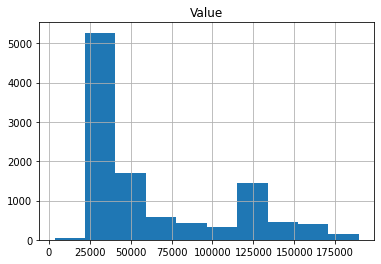

In [96]:
timeSeries.hist()

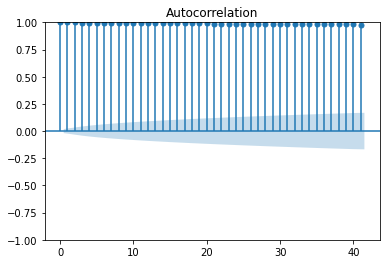

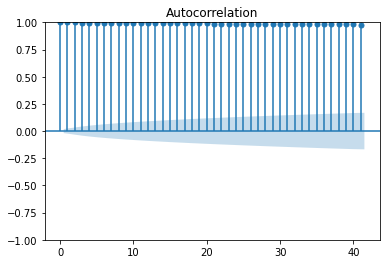

In [97]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(timeSeries)

In [98]:
timeSeries.shape

(10787, 1)

In [99]:
data1 = timeSeries[0:5394]
data2 = timeSeries[5394:]

In [100]:
data1.size

5394

In [101]:
data2.size

5393

In [102]:
data1.mean()

Value    38135.148128
dtype: float64

In [103]:
data2.mean()

Value    92589.226775
dtype: float64

In [104]:
data1.var()

Value    6.167577e+07
dtype: float64

In [105]:
data2.var()

Value    2.223631e+09
dtype: float64

In [106]:
from statsmodels.tsa.stattools import adfuller

In [107]:
test_result=adfuller(timeSeries['Value'])

In [108]:
def adfuller_test(Value):
    result=adfuller(Value)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

adfuller_test(timeSeries['Value'])

ADF Test Statistic : -0.07112124453841802
p-value : 0.9522400769147127
#Lags Used : 39
Number of Observations : 10747
Data is non-stationary 


Change the data to stationary

In [109]:
timeSeries['First Difference'] = timeSeries.diff().dropna()

In [110]:
timeSeries['Seasonal First Difference']=timeSeries['Value']-timeSeries['Value'].shift(12)

In [111]:
timeSeries.head(20)

,Value,First Difference,Seasonal First Difference
Date,,,
1970-01-01,3520.0,NaN,NaN
1970-04-01,3510.0,-10.0,NaN
1970-07-01,3540.0,30.0,NaN
1970-10-01,3620.0,80.0,NaN
1971-01-01,3740.0,120.0,NaN
1971-04-01,3890.0,150.0,NaN
1971-07-01,4010.0,120.0,NaN
1971-10-01,4200.0,190.0,NaN
1972-01-03,4350.0,150.0,NaN


In [112]:
adfuller_test(timeSeries['Seasonal First Difference'].dropna())

ADF Test Statistic : -14.98048386674468
p-value : 1.1640981457204917e-27
#Lags Used : 39
Number of Observations : 10735
Data is stationary


In [113]:
adfuller_test(timeSeries['First Difference'].dropna())

ADF Test Statistic : -17.56880752161733
p-value : 4.0613743604469985e-30
#Lags Used : 38
Number of Observations : 10747
Data is stationary


<AxesSubplot:xlabel='Date'>

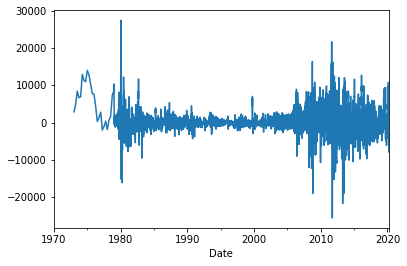

In [114]:
timeSeries['Seasonal First Difference'].plot()

<AxesSubplot:xlabel='Date'>

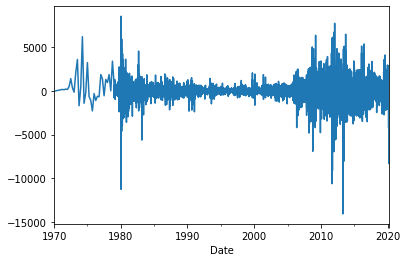

In [115]:
timeSeries['First Difference'].plot()

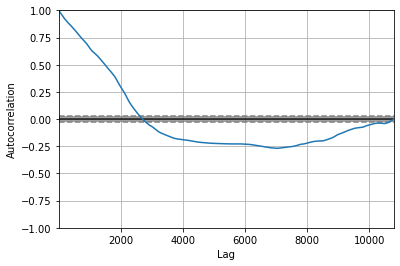

In [116]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(timeSeries['Value'])
plt.show()

Identify the parameters(p,d,q)

In [117]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

C:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


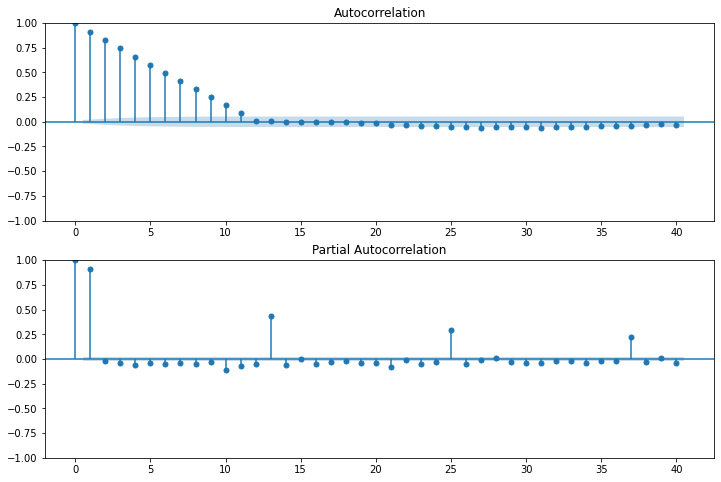

In [118]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeSeries['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeSeries['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [119]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(timeSeries['Value'], trace=True,
suppress_warnings=True)

ImportError: cannot import name 'MutableMapping' from 'collections' (C:\Python310\lib\collections\__init__.py)

In [127]:
from statsmodels.tsa.arima.model import ARIMA

In [129]:
model = ARIMA(timeSeries['Value'], order=(2,1,2))
model_fit_arima=model.fit()

In [130]:
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                10787
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -88691.002
Date:                Sat, 28 May 2022   AIC                         177392.005
Time:                        22:34:16   BIC                         177428.435
Sample:                    01-01-1970   HQIC                        177404.290
                         - 03-13-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7037      0.011    -65.062      0.000      -0.725      -0.683
ar.L2         -0.9376      0.010    -92.969      0.000      -0.957      -0.918
ma.L1          0.6846      0.012     55.671      0.000       0.661       0.709
ma.L2          0.9175      0.012     78.877      0.000       0.895       0.940
sigma2      8.156e+05   3277.654    248.838      0.000    8.09e+05    8.22e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):            210466.24
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

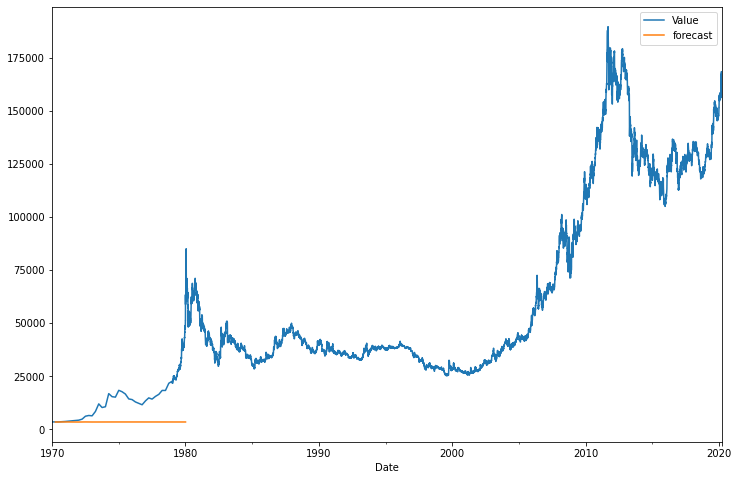

In [131]:
timeSeries['forecast']=model_fit_arima.predict(start= 1,end=300,dynamic=True)
timeSeries[['Value','forecast']].plot(figsize=(12,8))

In [132]:
model=sm.tsa.statespace.SARIMAX(timeSeries['Value'],order=(2, 1, 2),seasonal_order=(2,1,2,12))
results=model.fit()

In [133]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Value   No. Observations:                10787
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood              -88652.460
Date:                            Sat, 28 May 2022   AIC                         177322.920
Time:                                    22:43:35   BIC                         177388.484
Sample:                                01-01-1970   HQIC                        177345.031
                                     - 03-13-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9978      0.001  -3695.008      0.000      -1.999      -1.997
ar.L2         -1.0000      0.001  -1858.185      0.000      -1.001      -0.999
ma.L1          1.9978      0.008    252.968      0.000       1.982       2.013
ma.L2          1.0000      0.008    126.475      0.000       0.984       1.015
ar.S.L12      -0.9816      0.005   -181.797      0.000      -0.992      -0.971
ar.S.L24       0.0181      0.004      4.098      0.000       0.009       0.027
ma.S.L12   -6.377e-05      0.004     -0.016      0.987      -0.008       0.008
ma.S.L24      -0.9999      0.012    -84.963      0.000      -1.023      -0.977
sigma2      7.992e+05   1.89e-08   4.23e+13      0.000    7.99e+05    7.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):            199131.70
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+28. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='Date'>

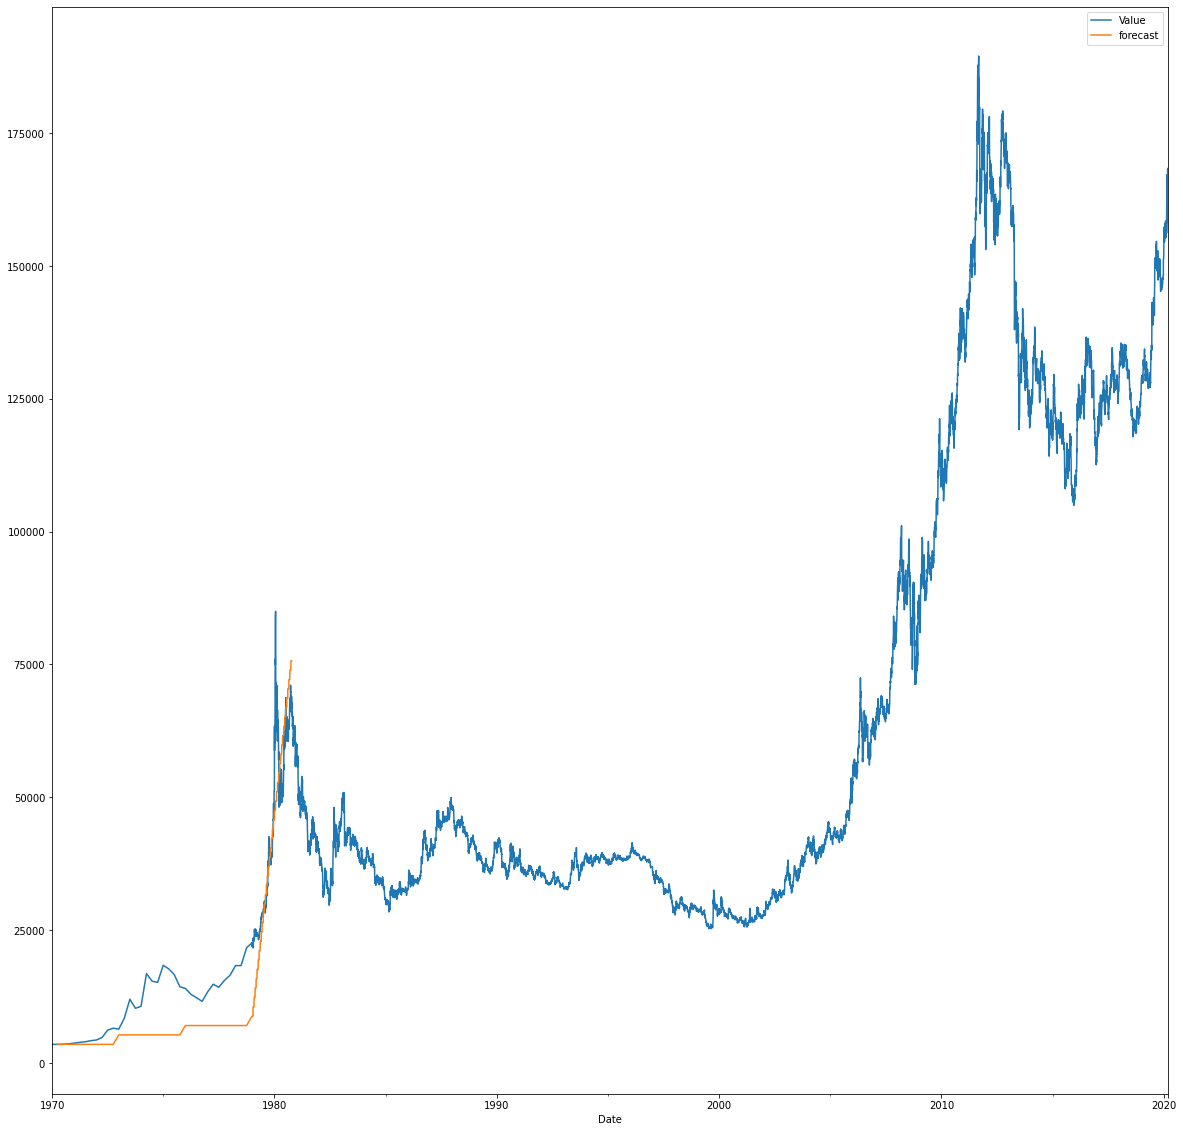

In [134]:
timeSeries['forecast']=results.predict(start= 1,end=500,dynamic=True)
timeSeries[['Value','forecast']].plot(figsize=(20,20))

In [135]:
from pandas.tseries.offsets import DateOffset
dates = [(pd.Timestamp('2020-03-13') + DateOffset(days=x)).to_period(freq='D') for x in range(0,2400)]

In [136]:
dates = pd.DataFrame(dates)

In [137]:
dates.columns = ['Date']

In [138]:
dates.set_index('Date',inplace=True)

In [139]:
future_dataset_df = timeSeries.append(dates)

C:\Users\Mathursan Balathas\AppData\Local\Temp\ipykernel_15176\1056996251.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_dataset_df = timeSeries.append(dates)


In [140]:
future_dataset_df.tail()

,Value,First Difference,Seasonal First Difference,forecast
Date,,,,
2026-10-03,NaN,NaN,NaN,NaN
2026-10-04,NaN,NaN,NaN,NaN
2026-10-05,NaN,NaN,NaN,NaN
2026-10-06,NaN,NaN,NaN,NaN
2026-10-07,NaN,NaN,NaN,NaN


C:\Python310\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='Date'>

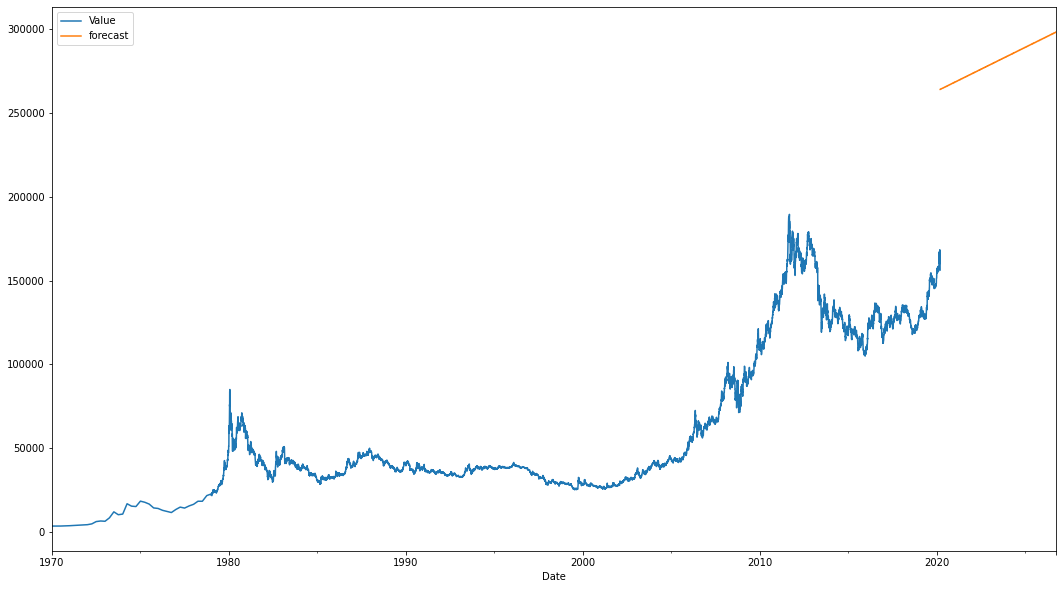

In [147]:
future_dataset_df['forecast'] = results.predict(start = '2020-03-14', end = '2026-10-07', dynamic= True)  
future_dataset_df[['Value', 'forecast']].plot(figsize=(18, 10)) 